# MAE 598 Project 1

## Rocket Soft Landing

### Introduction

Consider a simpliefied 2D formulation of a rocket landing problem. The rocket state $ x(t) $ is represented by the distances and velocities in X and Y directions respectively, orientation and the angular velocity, where $ t $ specifies time. The control inputs $ a(t) $ to the rocket are accelerations in  X and Y directions respectively.


#### State

$$ x(t) = [x, y, \dot{x}, \dot{y}, \theta, \dot{\theta}] $$

where,

$ x $ - Horizontal distence of the rocket CG from the origin

$ y $ - Vertical distence of the rocket CG from the origin

$ \dot{x} $ - Velocity of the rocket in *X* direction

$ \dot{y} $ - Velocity of the rocket in *Y* direction

$ \theta $ - Angle made by the longitudinal axis of the rocket with *Y*-axis

$ \dot{\theta} $ - Angular acceleration of the rocket about *Z*-axis



#### Action

$$ a(t) = [V, H] $$

where,

$ V $ - Thrust acceleartion at the base, along the longitudinal axis of the rocket

$ H $ - Thrust acceleartion at the base, perpendicular the longitudinal axis of the rocket

---



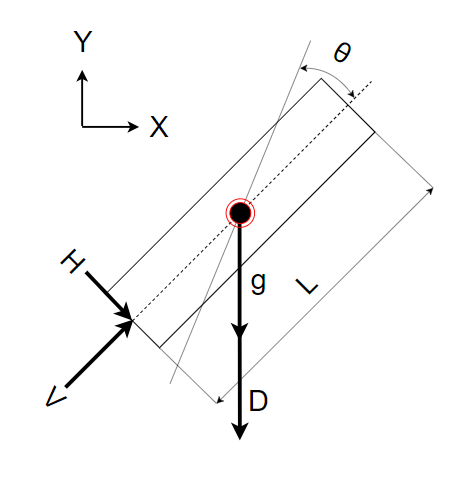


The rocket dynamics are described below:

$$
\begin{aligned}
\quad & \ddot{x} = V \sin\theta + H \cos\theta \\
\quad & \ddot{y} = V \cos\theta - H \sin\theta - D - g \\
\quad & \ddot{\theta} = (0.5 * L * H) \ / \  J
\end{aligned}
$$

The rocket mass $ M $ is assumed to be **one** to simplify the model.

Taking $ J = M L^2 \ / \ 12 $, $ \ \ddot{\theta} $ becomes
$$
\begin{aligned}
\ddot{\theta} = (6 * H) \ / \  L
\end{aligned}
$$

where,

$ \ddot{x} $ - Acceleration of the rocket in *X* direction

$ \ddot{y} $ - Acceleration of the rocket in *Y* direction

$ D $ - Acceleration due to the drag force experienced by the rocket

$ g $ - Acceleration due to gravity

$ J $ - Polar moment of inertia of the rocket about *Z*-axis

$ L $ - Length of the rocket

$ d $ - Diameter of the rocket

---


From the dynamics, a new state can be written in discrete time form as below:


$$
\begin{aligned}
\quad & x(t+1) = x(t) + \dot{x}(t) \ \Delta t + \ddot{x}(t) \ \Delta t^2 \\
\quad & y(t+1) = y(t) + \dot{y}(t) \ \Delta t + \ddot{y}(t) \ \Delta t^2 \\
\quad & \dot{x}(t+1) = \dot{x}(t) + \ddot{x}(t) \ \Delta t \\
\quad & \dot{y}(t+1) = \dot{y}(t) + \ddot{y}(t) \ \Delta t \\
\quad & \theta(t+1) = \theta(t) + \dot{\theta}(t) \ \Delta t + \ddot{\theta}(t) \ \Delta t^2 \\
\quad & \dot{\theta}(t+1) = \dot{\theta}(t) + \ddot{\theta}(t)
\end{aligned}
$$


where $ \Delta t $ is a time interval. 

Further let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$

where $ f_{\theta}(\cdot) $ is a neural network with parameters $ \theta $ which are to be determined through optimization.


For each time step we assign a loss as a function of the control input and the state: $ l(x(t), a(t)) $. In this example we will simply set $ l(x(t), a(t)) = 0 $ for all $ t=1...T-1 $ where $ T $ is the final time step. 

$$ 
\begin{aligned}
\quad l(x(T), a(T)) = \mathbb{E} \displaystyle \sum_{t=0}^{T-1} \|x(T) - x^*\|^2 = \mathbb{E} \displaystyle \sum_{t=0}^{T-1} w_1 \ (x(T) - 0)^2 + w_2 \ (y(T) - 0.5 L)^2 + w_3 \ (\dot{x}(T) - 0)^2 + w_4 \ (\dot{y}(T) - 0)^2 + w_5 \ (\theta(T) - 0)^2 + w_6 \ (\dot\theta(T) - 0)^2
\end{aligned}
$$

where,

$ x* $ - Target state at time $ T $

$ w $ - Weights applied to the state variable

This loss function encourages the rocket to reach zero state values for a stable landing condition.

---

Further, to generalize the controller behaviour a set of initial starting points is fed into the optimizer model. Also, to model the uncertainity in the state masurement we add some noise to the state values so that the controller output is robust against transients.


The optimization problem is now formulated as:

$$
\begin{aligned}
\quad & \min_{\theta} \mathbb{E}_{\{w(t) u(t) x(0)\}} \displaystyle \sum_{t=0}^{T-1} \|x(T) - x^*\|^2\\
\quad & s.t. \\
\quad & x(t+1)^{(i)} = x(t)^{(i)} + \dot{x}(t)^{(i)} \ \Delta t + \ddot{x}(t)^{(i)} \ \Delta t^2 \\
\quad & y(t+1)^{(i)} = y(t)^{(i)} + \dot{y}(t)^{(i)} \ \Delta t + \ddot{y}(t)^{(i)} \ \Delta t^2 \\
\quad & \dot{x}(t+1)^{(i)} = \dot{x}(t)^{(i)} + \ddot{x}(t)^{(i)} \ \Delta t \\
\quad & \dot{y}(t+1)^{(i)} = \dot{y}(t)^{(i)} + \ddot{y}(t)^{(i)} \ \Delta t \\
\quad & \theta(t+1)^{(i)} = \theta(t)^{(i)} + \dot{\theta}(t)^{(i)} \ \Delta t + \ddot{\theta}(t)^{(i)} \ \Delta t^2 \\
\quad & \dot{\theta}(t+1)^{(i)} = \dot{\theta}(t)^{(i)} + \ddot{\theta}(t)^{(i)} \\
\quad & a(t+1)^{(i)} = f_{\theta}(x(t)^{(i)}) \quad ~\forall t=1,...,T-1 \ and ~i=1...N
\end{aligned}
$$

While this problem is constrained it is easy to see that the objective function can be expressed as a function of $ x(T-1) $ and $ a(T-1) $ where $ x(T-1) $ as a function of $ x(T-2) $ and $ a(T-2) $ and so on. Thus it is essentially an unconstrained problem with respect to $ \theta $.

In the following we code this problem up with **PyTorch** which allows us to only build the forward pass of the loss (i.e. how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $ \nabla_{\theta} l(x(T), a(T)) $.
 


### Remarks

The constants and specifications of the rocket are inspired by SpaceX Starship.

Each state variable is initiated within ceratin bound of realistic staring space.

The controller the final layer in the contoller use sigmoid activation which output values between (0, 1). The In practice the longitudinal thrust $ V $ can be throttled but cannot change direction. The raw controller output is suitable to replicate this behavior. However, the lateral thrust $ H $ can chage direction in order to influence the orientaion of the rocket. Hence the output from the controller is rescaled into an interval of (-1, 1) to achieve this result.

Mean of the noise values is set to zero and the standard deviation is chosen based on the order of the bounding interval od the state variables, instead of applying a constant value across all variables.




### Code

In [1]:
# Import libraries
import random
import numpy as np
import time
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import logging

logger = logging.getLogger(__name__)


np.random.seed(9)
t.manual_seed(9)

In [2]:
# Environment parameters
dt = 0.5 # Time step (seconds)
g = 9.81e-3 # gravity constant (km / s^2)

# Specifications (The data is chosen based on SpaceX Starship)
d = 0.009 # Diameter of the vehicle (km)
L = 0.05 # Length of the vehicle (km)
l = 0.5 * L # Assumed position of CG along the length (km)
# l1 = l2 = L / 2

Md = 100. # Dry mass of the vehicle (Metric tonnes)
Mf = 0.5 * 1200. # Mass of the fuel (Metric tonnes). Total mass capacity is 1200, fuel level is taken as some fraction of that during re-entry
M = Md + Mf # Initial weight of the vehicle (Metric tonnes)

V = 15. # Total thrust of the main booster (Metric-tonnes-km / s^2) - Converted from 15 MN
H = 0.5 # Net thrust of the side booster booster (Metric-tonnes-km / s^2) - Converted from 0.5 MN
phi = 0.35 # Thrust vectoring limit (rads) (20 deg in each direction Left-Right)

D = 0.204 # Drag force constant, multiply by velocity to compute the force (Metric-tonnes / km)

ve = 6 * 3.28 # Exhaust velocity of the engines (km / s)
# Number of engines = 6 (3 vacuum + 3 sea level)

# Compute acceleration terms from the forces
Va = V / M
Ha = H / M
Dc = D / M

### Mulitple starts

In [3]:
# System Dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """       
        Units: km, metric tonnes, sec, rad
        
        state:
        state[0] = x (km)
        state[1] = y (km)
        state[2] = vx (km / s)
        state[3] = vy ((km / s)
        state[4] = theta (rad)
        state[5] = theta_dot (angular momentum) (rad / s)

        action:
        action[0]: thrust acceleration (Longitudinal)
        action[1]: thrust acceleration (Lateral)
        """

        for i in range(state.shape[0]):
            
            V_inst = Va * action[i, 0]
            H_inst = Ha * (action[i, 1] - 0.5) * 2. 

            # # Without drag
            # dvxdt = (V_inst * t.sin(state[i, 4])) + (H_inst * t.cos(state[i, 4]))
            # dvydt = (V_inst * t.cos(state[i, 4])) - (H_inst * t.sin(state[i, 4])) - g

            # With drag
            dvxdt = (V_inst * t.sin(state[i, 4])) + (H_inst * t.cos(state[i, 4]))
            dvydt = (V_inst * t.cos(state[i, 4])) - (H_inst * t.sin(state[i, 4])) - (Dc * (state[i, 4] ** 2)) - g
            dwdt = (6 * H_inst) / L

            # dMdt = V_inst / ve # Max fuel mass rate (Metric tonnes / s)
            
            # Construct step vectors
            dvxdt_step = t.tensor([[(dt**2), 0., dt, 0., 0., 0.]]) * dvxdt
            dvydt_step = t.tensor([[0., (dt**2), 0., dt, 0., 0.]]) * dvydt
            dwdt_step = t.tensor([[0., 0., 0., 0., (dt**2), dt]]) * dwdt
            
            delta = dvxdt_step + dvydt_step + dwdt_step

            if i == 0:
                delta_batched = delta
                # print(delta_batched, i)
                
            else:
                delta_batched = t.cat((delta_batched, delta), dim=0)
                # print(delta_batched, i)
  
        # print(delta_batched)
        
        state = state + delta_batched

        # Update state
        step_mat = t.tensor([[1., 0., 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [dt, 0., 1., 0., 0., 0.],
                             [0., dt, 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., dt, 1.]])
        
        state = t.matmul(state, step_mat)

        if add_uncertainty:
            print("Uncertainty added!")
            noise_gen = np.hstack([np.random.normal(0, 0.05, (state.shape[0], 1)),
                        np.random.normal(0, 0.1, (state.shape[0], 1)),
                        np.random.normal(0, 0.001, (state.shape[0], 1)),
                        np.random.normal(0, 0.001, (state.shape[0], 1)),
                        np.random.normal(0, 0.05, (state.shape[0], 1)),
                        np.random.normal(0, 0.001, (state.shape[0], 1))])

            noise = t.tensor(noise_gen).float()
            state = state + 0.001 * noise
    
        return state
    
t.autograd.set_detect_anomaly(True)

In [4]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            # nn.Linear(dim_hidden, 2 * dim_hidden),
            # nn.Tanh(),
            # nn.Linear( 2 * dim_hidden, dim_hidden),
            # nn.Tanh(),
            # nn.Linear(dim_hidden, dim_hidden),
            # nn.Tanh(),
            # nn.ReLU(),
            nn.Linear(dim_hidden, dim_output),
            # nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        # print("Action: ", action)
        # print("Action dim: ", action.shape)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        batch_sz = 20
        bounds = np.array([[-1.5, 1.5], 
                           [5, 6], 
                           [-0.05, 0.05], 
                           [-0.1, 0], 
                           [-1.57, 1.57],
                           [-0.05, 0.05]]) # angle in rads
       
        state = t.tensor(np.random.uniform(bounds[:,0], bounds[:, 1], (batch_sz, bounds.shape[0])), requires_grad=False).float()
        print('Dim. state: ', state.shape)
        print('Initial state: ', state)
        return state
    
    
    def error(self, state):
        error = (1 * state[:, 0]**2 + 2 * (state[:, 1] - l)**2 + 30 * state[:, 2]**2 + 40 * state[:, 3]**2 + 1 * state[:, 4]**2 + 1 * state[:, 5]**2).mean()
        # error = t.nn.functional.normalize(state**2, dim=0).mean().sum()
        return error

In [6]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1)
        # self.optimizer = optim.Adam(self.parameters, lr=0.001)
        # self.optimizer = optim.SGD(self.parameters, lr=0.01)
        # self.optimizer = optim.SGD(self.parameters, lr=0.1, momentum=0.9)       
        # self.optimizer = optim.Adagrad(self.parameters, lr=0.1)
        # self.optimizer = optim.RMSprop(self.parameters, lr=0.0001)

        self.lossVal = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            self.lossVal.append(loss.detach().numpy())
            print('[%d] loss: %.6f' % (epoch + 1, loss))
            
            # self.visualize()
            if epoch % 3 == 2:
                self.visualize()


    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        print(data.shape)
        fig = plt.figure(figsize=(40, 8))       
        ax1 = fig.add_subplot(161)
        ax2 = fig.add_subplot(162)
        ax3 = fig.add_subplot(163)
        ax4 = fig.add_subplot(164)
        ax5 = fig.add_subplot(165)


        for i in range(data.shape[1]):
            x = data[:, i, 0]
            y = data[:, i, 1]

            vx = data[:, i, 2]
            vy = data[:, i, 3]
            
            theta = data[:, i, 4]
            omega = data[:, i, 5]
            
            ax1.plot(x, y)
            ax1.set_xlabel('[X]')
            ax1.set_ylabel('[Y]')
            ax1.set_title('Rocket Trajectory')
            # ax1.set_xlim(-2.5, 2.5)
            # ax1.set_ylim(0, 7)
            ax1.grid(axis='y', color='0.95')
            
            ax2.plot(vx)
            ax2.set_xlabel('[Time]')
            ax2.set_ylabel('[Vx]')
            ax2.set_title('Velocity in X-direction')
            # ax2.set_xlim(0, data.shape[0])
            # ax2.set_ylim(-0.2, 0.2)
            ax2.grid(axis='y', color='0.95')
            
            ax3.plot(vy)
            ax3.set_xlabel('[Time]')
            ax3.set_ylabel('[Vy]')
            ax3.set_title('Velocity in Y-direction')
            # ax3.set_xlim(0, data.shape[0])
            # ax3.set_ylim(-0.3, 0.3)
            ax3.grid(axis='y', color='0.95')
            
            ax4.plot(theta)
            ax4.set_xlabel('[Time]')
            ax4.set_ylabel('[Theta]')
            ax4.set_title('Rocket Orientation')
            # ax4.set_xlim(0, data.shape[0])
            # ax4.set_ylim(-2, 2)
            ax4.grid(axis='y', color='0.95')
            
            ax5.plot(omega)
            ax5.set_xlabel('[Time]')
            ax5.set_ylabel('[Omega]')
            ax5.set_title('Angualr Velocity about Z-direction')
            # ax5.set_xlim(0, data.shape[0])
            # ax5.set_ylim(-0.3, 0.3)
            ax5.grid(axis='y', color='0.95')
            
        plt.show()

Dim. state:  torch.Size([20, 6])
Initial state:  tensor([[-1.4689e+00,  5.5019e+00, -4.2267e-04, -8.6617e-02, -1.1238e+00,
          0.0000e+00],
        [-2.4448e-01,  5.2481e+00, -4.1594e-02, -6.5450e-02, -1.0463e+00,
          0.0000e+00],
        [ 1.3529e+00,  5.0387e+00,  1.9911e-02, -4.2724e-02,  1.2497e+00,
          0.0000e+00],
        [ 1.4351e-01,  5.7024e+00, -1.1352e-02, -3.0556e-02,  1.0201e+00,
          0.0000e+00],
        [ 1.3216e+00,  5.8037e+00,  4.8336e-02, -8.3036e-02,  6.6206e-02,
          0.0000e+00],
        [ 4.4862e-01,  5.8608e+00,  4.7085e-02, -8.1446e-02, -8.0662e-01,
          0.0000e+00],
        [ 1.2188e+00,  5.7583e+00, -1.5310e-02, -5.3647e-02,  3.4709e-01,
          0.0000e+00],
        [-6.6078e-02,  5.4356e+00,  3.7041e-02, -8.1264e-02,  5.8930e-01,
          0.0000e+00],
        [ 1.2756e+00,  5.0395e+00,  1.4712e-02, -3.6195e-02, -1.2027e-01,
          0.0000e+00],
        [-1.3843e+00,  5.1695e+00,  2.9455e-02, -8.3739e-02, -1.1344e+00,
    

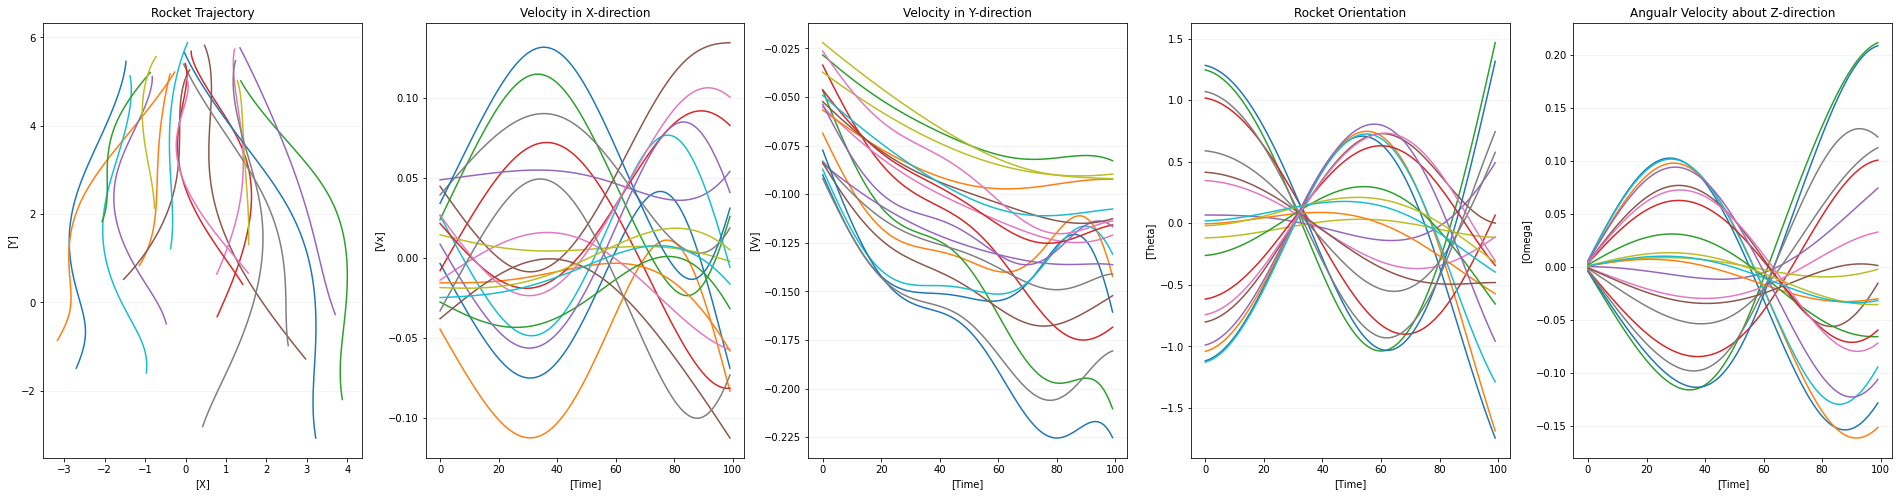

[4] loss: 8.532637
[5] loss: 4.109411
[6] loss: 2.924112
(100, 20, 6)


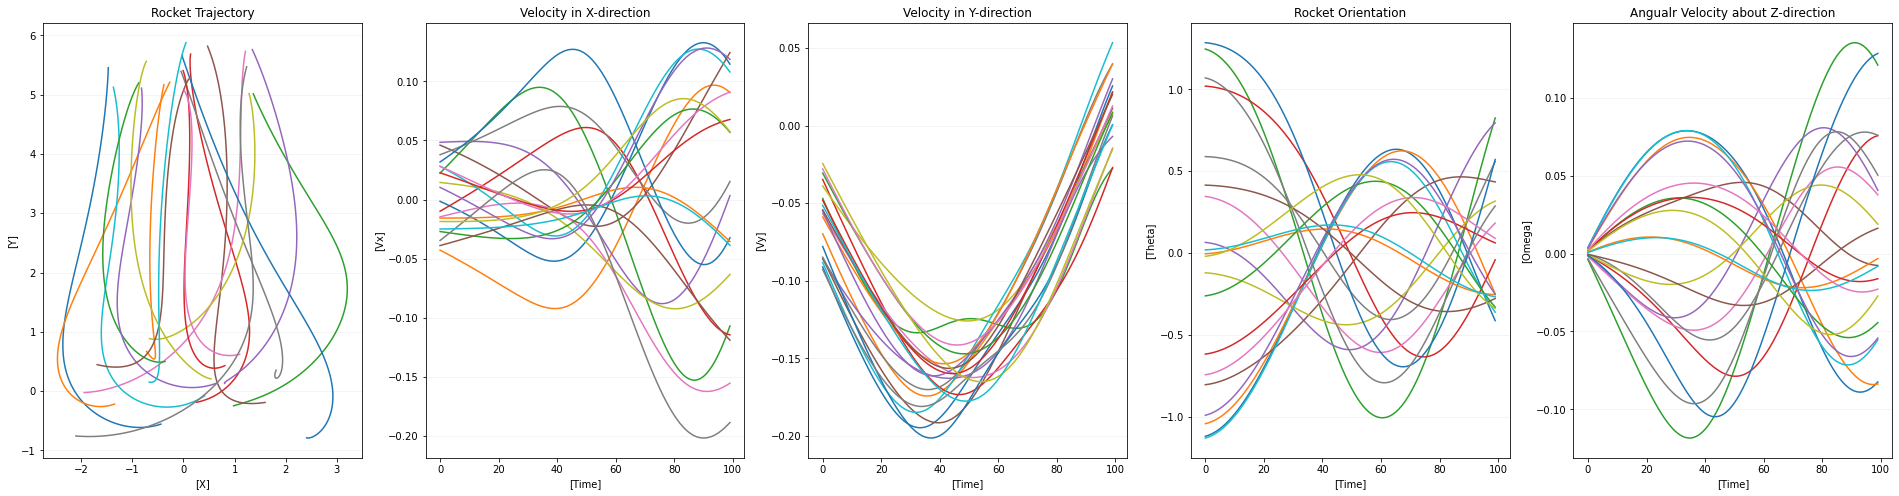

[7] loss: 2.299903
[8] loss: 1.708466
[9] loss: 1.282677
(100, 20, 6)


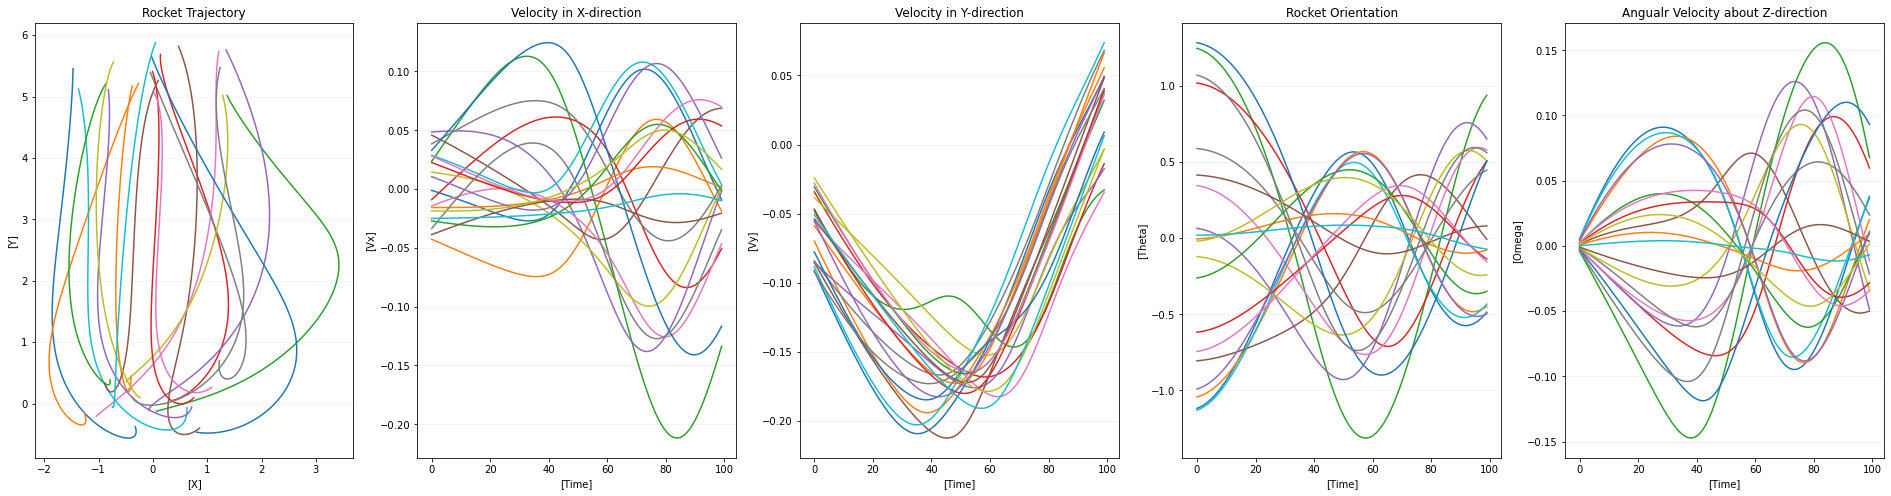

[10] loss: 0.758171
[11] loss: 0.544981
[12] loss: 0.427865
(100, 20, 6)


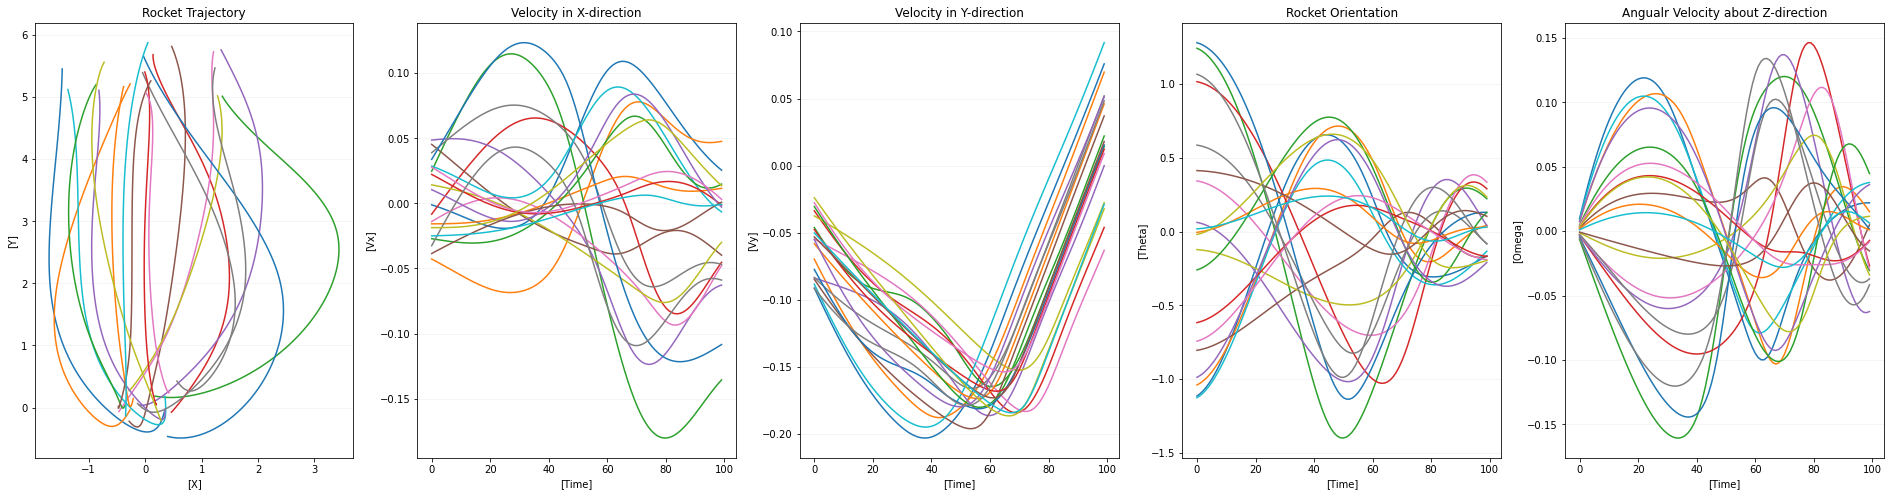

[13] loss: 0.384026
[14] loss: 0.350731
[15] loss: 0.279943
(100, 20, 6)


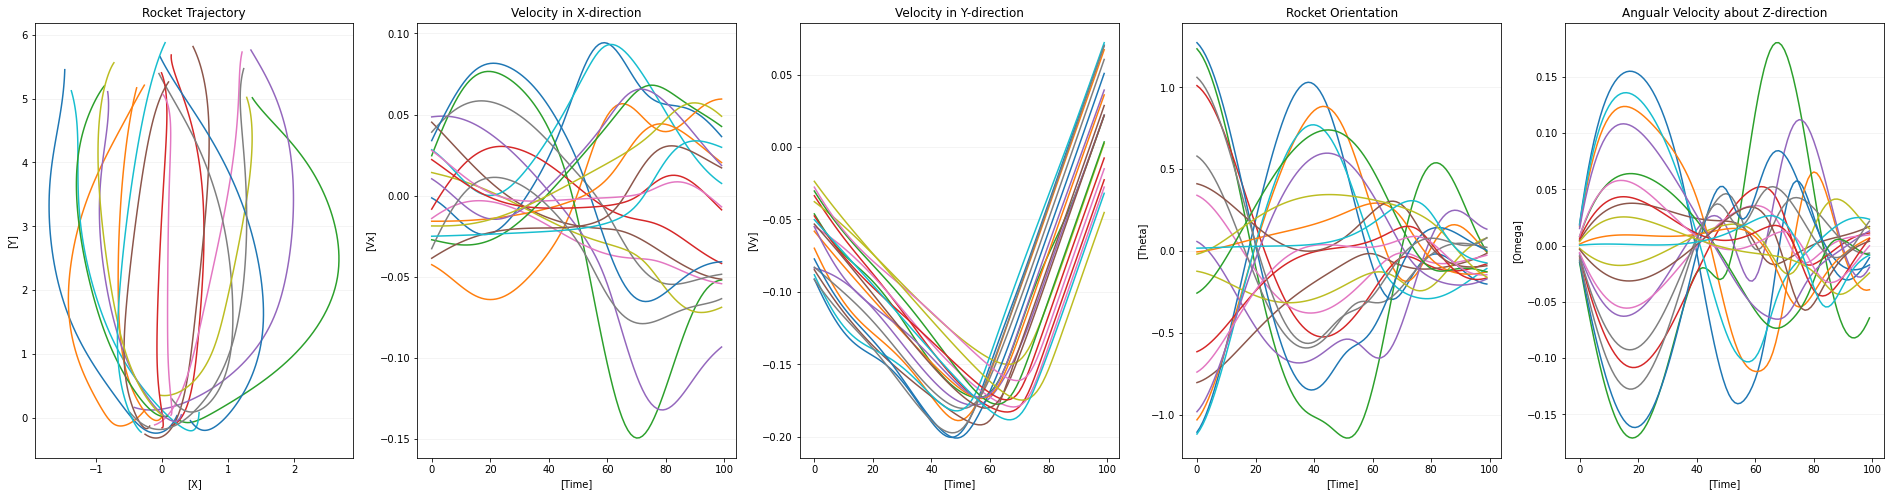

[16] loss: 0.215766
[17] loss: 0.173737
[18] loss: 0.143047
(100, 20, 6)


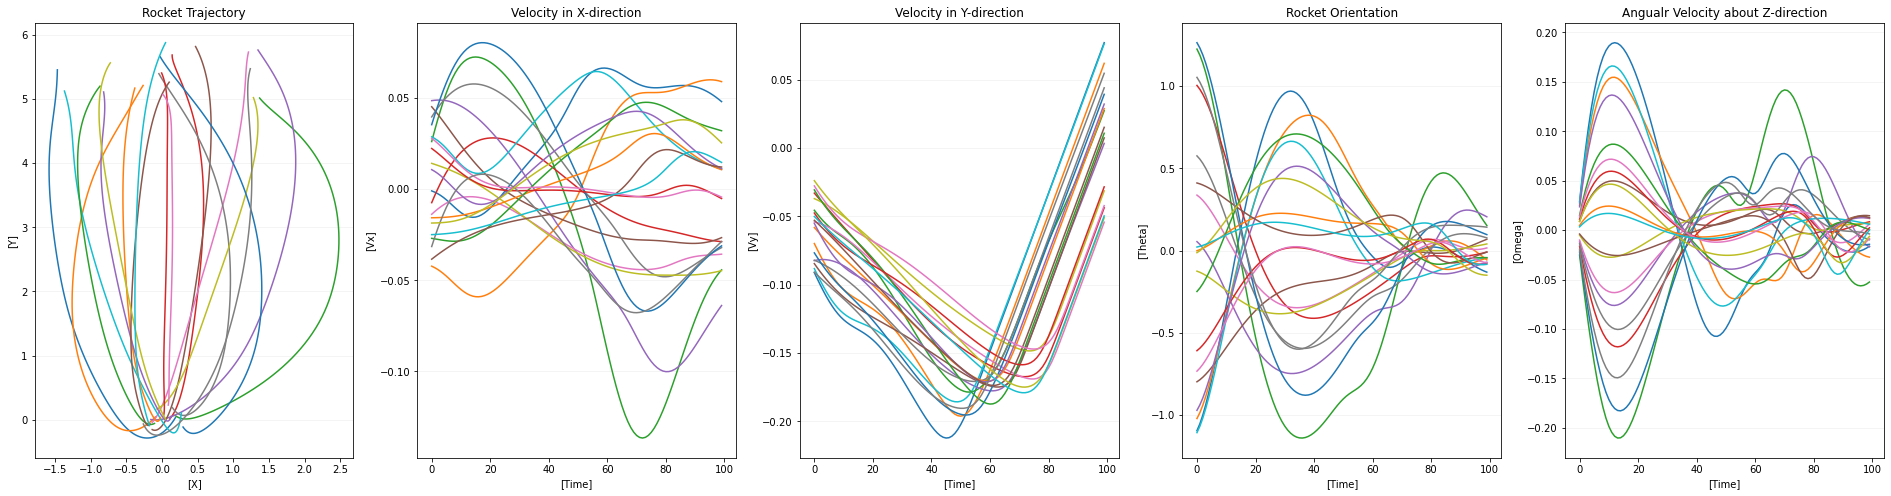

[19] loss: 0.115261
[20] loss: 0.107038
[21] loss: 0.092991
(100, 20, 6)


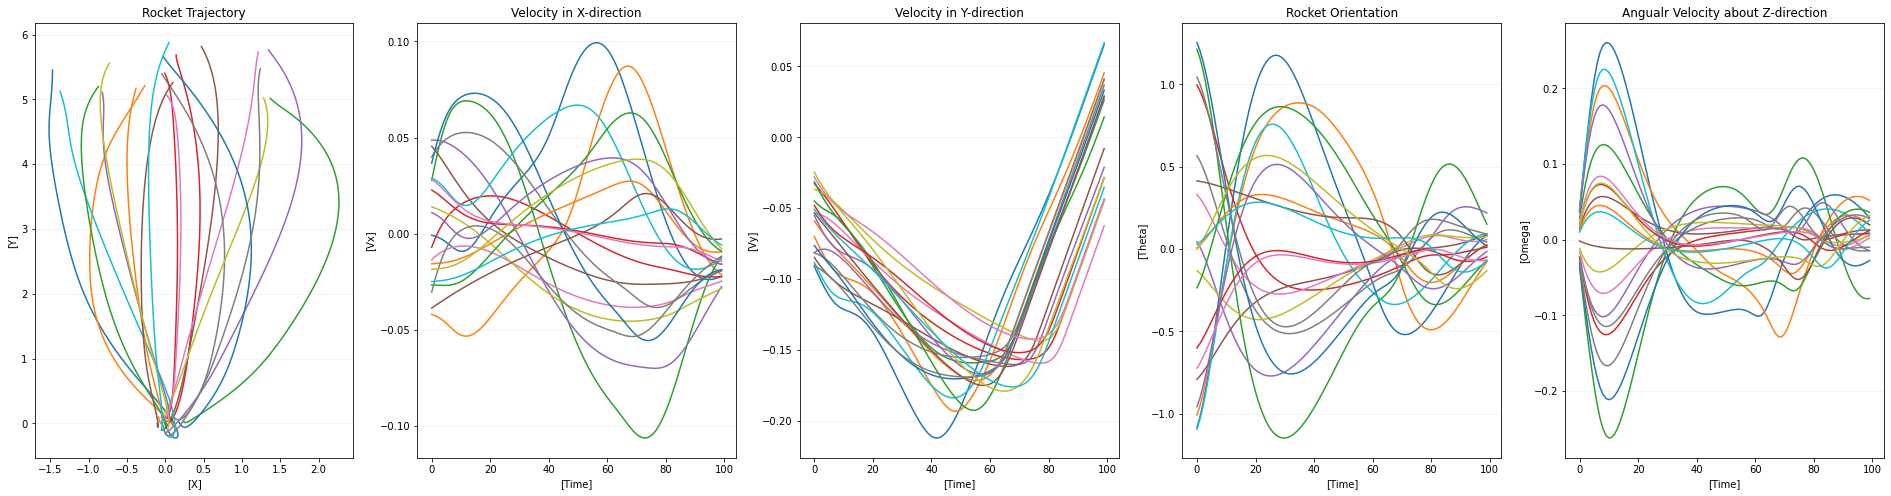

[22] loss: 0.064436
[23] loss: 0.047769
[24] loss: 0.031314
(100, 20, 6)


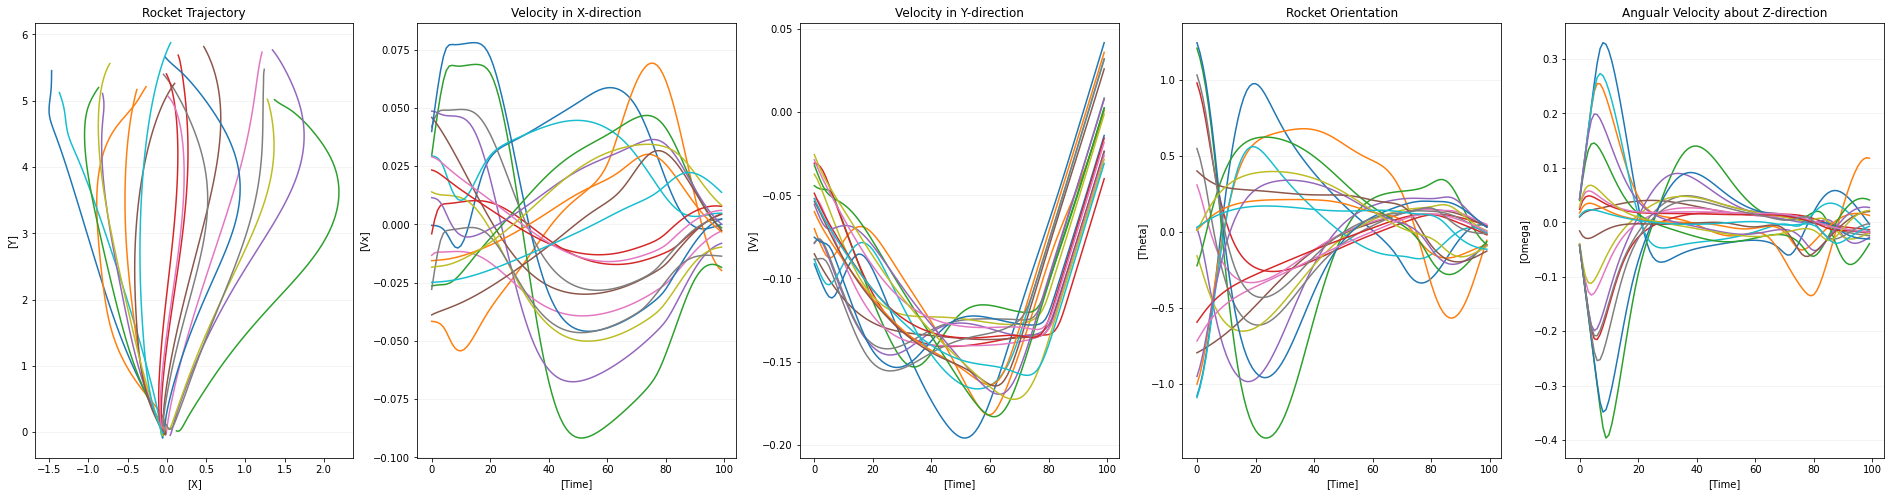

[25] loss: 0.019088


In [ ]:
# Now it's time to run the code!

add_uncertainty = False

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(200)  # solve the optimization problem



In [ ]:
plt.plot(o.lossVal,'r')
plt.show()

## Discussion

The weights are tuned such the state variables contributing a higher value are penalized. In this problem both velocities would not reduce to zero, so the weights on these variables are raised to drive the loss value down.

LBFGS optimizer in consistently converges to a solution albeit slowly. Other optimizers such Adam and SGD were tested but, the solution would not converge and the values would oscillate after certain epochs.

Increasing the number of layers in the controller neuralnet did not improve the solution greatly, however the computation overhead increased greatly slowing down the training process. Various combinations of the time step width and the number of time steps were tried before arriving at the values used in the code to allow for the simulation to respond to the system dynamics.

## Realistic model

We can further improve the dynamics of the model by introducing additional parameters such as mass of the rocket, fuel expenditure and thrust vectoring. The folowing models expands on these aspects.

The rocket state $ x(t) $ is expanded to include a new variable $ m(t) $ which describes the mass of the rocket at time (t). The control of the rocket is enhanced by introducing a vectoring angle $ \phi(t) $ for thrust $ V $.


State

$$ x(t) = [x, y, \dot{x}, \dot{y}, \theta, \dot{\theta}, m] $$

where,

$ x $ - Horizontal distence of the rocket CG from the origin

$ y $ - Vertical distence of the rocket CG from the origin

$ \dot{x} $ - Velocity of the rocket in *X* direction

$ \dot{y} $ - Velocity of the rocket in *Y* direction

$ \theta $ - Angle made by the longitudinal axis of the rocket with *Y*-axis

$ \dot{\theta} $ - Angular acceleration of the rocket about *Z*-axis

$ m $ - Mass of the rocket

Action

$$ a(t) = [V, H, \phi] $$

where,

$ V $ - Thrust force at the base, along the longitudinal axis of the rocket

$ H $ - Thrust force at the top, perpendicular the longitudinal axis of the rocket

$ \phi $ - Vectoring angle of thrust V at the base


The rocket dynamics are described below:

$$
\begin{aligned}
\quad & \ddot{x} = \frac{V \sin(\theta + \phi) + H \cos\theta}{m} \\
\quad & \ddot{y} = \frac{V \cos(\theta + \phi) - H \sin\theta - D}{m} - g \\
\quad & \ddot{\theta} = \frac{L}{2} \Big(\frac{V \sin\phi - H}{J}\Big)
\end{aligned}
$$



Taking $ J = m L^2 \ / \ 12 $, $ \ \ddot{\theta} $ becomes
$$
\begin{aligned}
\ddot{\theta} = \frac{6 \ (V \sin\phi - H)}{m L}
\end{aligned}
$$

$$
\begin{aligned}
\dot{m} = \frac{V}{v_e}
\end{aligned}
$$

where,

$ \ddot{x} $ - Acceleration of the rocket in *X* direction

$ \ddot{y} $ - Acceleration of the rocket in *Y* direction

$ D $ - Drag force experienced by the rocket

$ g $ - Acceleration due to gravity

$ J $ - Polar moment of inertia of the rocket about *Z*-axis

$ L $ - Length of the rocket

$ d $ - Diameter of the rocket

$ v_e $ - Exhaust velocity of the engines



Drag force is calculated using the formula: 

$$ D = \frac{1}{2} \ C_d \ \rho_{air} \ A \ V_b^2 $$


where,

$ C_d $ - Drag coefficient of the body in air

$ \rho_{air} $ - Density of air

$ A $ - Effective area of the body

$ V_b $ - Velocity of the body




From the dynamics the new state can be written in discrete time form as below:


$$
\begin{aligned}
\quad & x(t+1)^{(i)} = x(t) + \dot{x}(t) \ \Delta t + \ddot{x}(t) \ \Delta t^2 \\
\quad & y(t+1)^{(i)} = y(t) + \dot{y}(t) \ \Delta t + \ddot{y}(t) \ \Delta t^2 \\
\quad & \dot{x}(t+1)^{(i)} = \dot{x}(t) + \ddot{x}(t) \ \Delta t \\
\quad & \dot{y}(t+1)^{(i)} = \dot{y}(t) + \ddot{y}(t) \ \Delta t \\
\quad & \theta(t+1)^{(i)} = \theta(t) + \dot{\theta}(t) \ \Delta t + \ddot{\theta}(t) \ \Delta t^2 \\
\quad & \dot{\theta}(t+1)^{(i)} = \dot{\theta}(t) + \ddot{\theta}(t) \\
\quad & m(t+1)^{(i)} = m(t) - \dot{m}(t) \\
\end{aligned}
$$


where $ \Delta t $ is a time interval. 

Further let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$

where $ f_{\theta}(\cdot) $ is a neural network with parameters $ \theta $ which are to be determined through optimization.

For each time step we assign a loss as a function of the control input and the state: $ l(x(t), a(t)) $. In this example we will simply set $ l(x(t), a(t)) = 0 $ for all $ t=1...T-1 $ where $ T $ is the final time step. 

$$ 
\begin{aligned}
\quad l(x(T), a(T)) = \mathbb{E} \displaystyle \sum_{t=0}^{T-1} \|x(T) - x^*\|^2 = \mathbb{E} \displaystyle \sum_{t=0}^{T-1} w_1 \ (x(T) - 0)^2 + w_2 \ (y(T) - 0.5 L)^2 + w_3 \ (\dot{x}(T) - 0)^2 + w_4 \ (\dot{y}(T) - 0)^2 + w_5 \ (\theta(T) - 0)^2 + w_6 \ (\dot\theta(T) - 0)^2 + w_7 \ (M_i - m(T))^2
\end{aligned}
$$

where,

$ x* $ - Target state at time $ T $

$ w $ - Weights applied to the state variable

$ M_i $ - Mass of the rocket at the start of the landing maneuver

This loss function encourages the rocket to reach zero state values for a stable landing condition.

The optimization problem is now formulated as:

$$
\begin{aligned}
\quad & \min_{\theta} \mathbb{E} \displaystyle \sum_{t=0}^{T-1} \|x(T) - x^*\|^2\\
\quad & s.t. \\
\quad & x(t+1) = x(t) + \dot{x}(t) \ \Delta t + \ddot{x}(t) \ \Delta t^2 \\
\quad & y(t+1) = y(t) + \dot{y}(t) \ \Delta t + \ddot{y}(t) \ \Delta t^2 \\
\quad & \dot{x}(t+1) = \dot{x}(t) + \ddot{x}(t) \ \Delta t \\
\quad & \dot{y}(t+1) = \dot{y}(t) + \ddot{y}(t) \ \Delta t \\
\quad & \theta(t+1) = \theta(t) + \dot{\theta}(t) \ \Delta t + \ddot{\theta}(t) \ \Delta t^2 \\
\quad & \dot{\theta}(t+1) = \dot{\theta}(t) + \ddot{\theta}(t) \\
\quad & m(t+1) = m(t) - \dot{m}(t) \\
\quad & a(t) = f_{\theta}(x(t)) ~\forall t=1...T-1
\end{aligned}
$$

The model presented above was implemented but sadly could produce the desired results. Therefore the simplified model described at the beginning of this page was used.


# System Dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """       
        Units: km, metric tonnes, sec, rad
        
        state:
        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
        state[5] = theta_dot (angular momentum)
        state[6] = mass
        
        
        action:
        action[0]: thrust (Main booster)
        action[1]: thrust_h (thrust side booster)
        action[2]: thrust_vectoring_angle (Main booster)
        """

        for i in range(state.shape[0]):
            
            T_inst = T * action[i, 0]
            H_inst = H * action[i, 1]
            phi_inst = phi * action[i, 2]
                       
            dMdt = T_inst / ve # Max fuel mass rate (Metric tonnes / s)

            # Compute accelerations
            # dvxdt = ((T_inst * (phi_inst * action[i, 2])) + H_inst + (D * (state[i, 2] ** 2))) / state[i, 6]
            dvxdt = ((T_inst * (phi_inst + state[i, 4])) + H_inst) / state[i, 6]

            dvydt = (((T_inst * (1 - phi_inst * state[i, 4])) - (H_inst * state[i, 4]) + (D * (state[i, 3] ** 2))) / state[i, 6]) - g
            dwdt = (6 * ((T_inst * phi_inst) - H_inst)) / (state[i, 6] * L)
            dMdt = T_inst / ve # Max fuel mass rate (Metric tonnes / s)
            
            # Construct step vectors
            dvxdt_step = t.tensor([[(dt**2), 0., dt, 0., 0., 0., 0.]]) * dvxdt
            dvydt_step = t.tensor([[0., (dt**2), 0., dt, 0., 0., 0.]]) * dvydt
            dwdt_step = t.tensor([[0., 0., 0., 0., (dt**2), dt, 0.]]) * dwdt
            dMdt_step = t.tensor([[0., 0., 0., 0., 0., 0., -dt]]) * dMdt
            
            delta = dvxdt_step + dvydt_step + dwdt_step + dMdt_step

            if i == 0:
                delta_batched = delta
                # print(delta_batched, i)
                
            else:
                delta_batched = t.cat((delta_batched, delta), dim=0)
                # print(delta_batched, i)
  
        # print(delta_batched)
        
        state = state + delta_batched
        
        
        # Update state
        step_mat = t.tensor([[1., 0., 0., 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0., 0.],
                             [dt, 0., 1., 0., 0., 0., 0.],
                             [0., dt, 0., 1., 0., 0., 0.],
                             [0., 0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., dt, 1., 0.],
                             [0., 0., 0., 0., 0., 0., 1.]])
        
        state = t.matmul(state, step_mat)
        
        # print(state.shape)

        return state
    


In [ ]:
from matplotlib.patches import Rectangle

plt.gca().add_patch(Rectangle((0.5,0.5),0.05,0.2,
                    angle=-90,
                    edgecolor='red',
                    facecolor='red',
                    alpha=0.1))